# Missed doctor appointments

## Contents
1. [Introduction](#intro)
2. [Data exploration](#data_exploration)
3. [Data wrangling](#wrangling)
4. [Data Analysis](#data_analysis)
5. [Conclusions](#conclusions)

<a id=intro></a>
## Introduction
This project was created as part of the [Udacity](https://www.udacity.com/) 'Data Analyst' nano-degree program.
It investigates a [Kaggle dataset](https://www.kaggle.com/joniarroba/noshowappointments), which includes anonymized data about ~100,000 medical appointments in Brazil.
The aim of this project is to study some factors that may contribute to a patient missing their scheduled appointment.

Specifically, we aim to answer the following questions:

### Questions to answer
1. What proportion of scheduled appointments are missed in each neighborhood? Is it the same everywhere, or not?
2. Are there any patients that repeatedly miss their appointment?
3. Does sending an SMS help reduce the number of people that miss their appointment?
4. Do older or younger people tend to miss their appointment more?

Note that the analysis in this project is merely based on descriptive statistics and visiual observations of the data.
For this reason, any conclusions we make are only based on correlation of two variables.
We cannot say anything about causation.
For more conclusive results, one must use either inferential statistics or machine-learning algorithms, both of which go beyond the scope of this project.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [3]:
def camel_to_snake(name):
    '''
    Function to convert CamelCase to snake_case.
    See https://stackoverflow.com/questions/1175208
    '''
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

<a id=data_exploration></a>
## Import and explore data file

We first read the data from the given csv file.

In [4]:
df_doc_apps = pd.read_csv('doc_appointment.csv')

In [5]:
df_doc_apps.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


The first step is to look at some information about the columns of the table.

In [6]:
df_doc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Firstly, the names of the columns are a bit inconsistent with each other.  Some are in camel-case, some are in snake-case.  There are also some spelling mistakes in the names of the columns.  Although this is not strictly necessary, it would be good to fix these to avoid any future confusions.

Another observation is that there are **not any missing data** from the table.

Let us now look at the different columns in more detail.

In [7]:
df_doc_apps.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

First, PatientId and AppointmentID are simple identifiers, so we choose to store them as strings instead of `float` or `int`.

Scholarship, Hipertension, Diabetes, Alcoholism and No-Show are all binary variables.  However, the first 3 are represented by integers (0 or 1) and the latter is a string (Yes or No).  We will need to change these to `bool` type.  Note that, although SMS_received has only 2 distinct values, according to the data provider, this column repressents the number of messages a patient has received and it can in principle take other values.  Similarly, Handcap represents the number of disabilities an individual has and therefore it correctly takes multiple integer values.

Additionally, we will need to change the type of the two date fields, ScheduledDay and AppointmentDay, from string to `datetime`.

Next, we check whether there are any duplicate entries in the table.

In [8]:
sum(df_doc_apps.duplicated())

0

Seemingly, there are no duplicate entries.  However, at a later stage in the analysis we realized that there are appointments registered multiple times with different ids and possibly scheduled at slightly different times.

In [9]:
sum(df_doc_apps.duplicated(df_doc_apps.columns.drop(['AppointmentID', 'ScheduledDay'])))

5155

Finally, we check some descriptive statistics for the different fields that will help us identify any additional irregularities.

In [10]:
df_doc_apps.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


The only obvious problem is the minimum value of the Age field, which is -1.  We should remove these problematic entries.

To summarize, this is the actions we will need to take, during the cleaning of the data:
1. Convert PatientId and AppointmentID to `str`
2. Convert ScheduledDay and AppointmentDay to `datetime`
3. Convert Scholarship, Hipertension, Diabetes, Alcoholism and No-show to `bool`
4. Remove entries with Age -1
5. Remove duplicated entries
6. Fix names of columns. Use lower case with undescores. Coorect typos (e.g. Hipertension)

<a id=wrangling></a>
## Data cleaning

### Rename columns

First, we convert the names of all columns to snake-case.  For this we use the method described in [StackExchange](https://stackoverflow.com/questions/1175208).

In [11]:
df_doc_apps = df_doc_apps.rename(columns = camel_to_snake)

df_doc_apps.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Then we manually fix spelling mistakes and replace the hyphen in no-show with an underscore.

In [12]:
new_columns = {
    'neighbourhood':'neighborhood',
    'hipertension':'hypertension',
    'handcap':'handicap',
    'no-show':'no_show'
}

df_doc_apps = df_doc_apps.rename(columns = new_columns)

df_doc_apps.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Fix data types

First, we convert patient_id and appointment_id to type `str`.  For patient_id, since it was stored as a `float`, we need to remove the decimal point and ddecimal part.

In [13]:
df_doc_apps.patient_id = df_doc_apps.patient_id.astype(str).apply(lambda x: x.split('.')[0])

In [14]:
df_doc_apps.appointment_id = df_doc_apps.appointment_id.astype(str)

In [15]:
df_doc_apps.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Next, we convert scheduled_day and appointment_day to `datetime`.

In [16]:
df_doc_apps.scheduled_day = df_doc_apps.scheduled_day.apply(pd.to_datetime)
df_doc_apps.appointment_day = df_doc_apps.appointment_day.apply(pd.to_datetime)
df_doc_apps.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


We then convert scholarship, hypertension, diabetes and alcoholism to `bool`.

In [17]:
for col in ['scholarship', 'hypertension', 'diabetes', 'alcoholism']:
    df_doc_apps[col] = df_doc_apps[col].astype(bool)
df_doc_apps.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,False,True,False,False,0,0,No
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,False,False,False,False,0,0,No
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,False,False,False,False,0,0,No
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,False,False,False,False,0,0,No
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,False,True,True,False,0,0,No


Finally, we do the same for the no_show column.  Here we need to use a test since data here are stored as Yes/No.

In [18]:
df_doc_apps.no_show = df_doc_apps.no_show.apply(lambda x: x == 'Yes')
df_doc_apps.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,False,True,False,False,0,0,False
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,False,False,False,False,0,0,False
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,False,False,False,False,0,0,False
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,False,False,False,False,0,0,False
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,False,True,True,False,0,0,False


### Remove irregular data

We need to drop those rows that have negative age.  We use a query to find the index of these rows and then drop them.

In [19]:
df_doc_apps.drop(index = df_doc_apps.query('age == -1').index, inplace = True)

In [20]:
df_doc_apps.query('age < 0')

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show


No negative age rows remain

### Remove duplicated entries

We need to remove the duplicated entries.  Recall that such entries still have different appointmemnt ids and therefore we need to ignore that column when identifying duplicates.

In [21]:
df_doc_apps.drop_duplicates(df_doc_apps.columns.drop(['appointment_id', 'scheduled_day']), inplace = True)

In [22]:
sum(df_doc_apps.duplicated(df_doc_apps.columns.drop(['appointment_id', 'scheduled_day'])))

0

No duplicates remain.

Finally, let us verify that all our changes are done properly.

In [23]:
df_doc_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105371 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   patient_id       105371 non-null  object             
 1   appointment_id   105371 non-null  object             
 2   gender           105371 non-null  object             
 3   scheduled_day    105371 non-null  datetime64[ns, UTC]
 4   appointment_day  105371 non-null  datetime64[ns, UTC]
 5   age              105371 non-null  int64              
 6   neighborhood     105371 non-null  object             
 7   scholarship      105371 non-null  bool               
 8   hypertension     105371 non-null  bool               
 9   diabetes         105371 non-null  bool               
 10  alcoholism       105371 non-null  bool               
 11  handicap         105371 non-null  int64              
 12  sms_received     105371 non-null  int64              
 13 

<a id=data_analysis></a>
## Data analysis

### Distribution of missed appointments among neighborhoods
Here, we answer the first question posed in the introduction:
> What proportion of scheduled appointments are missed in each neighborhood? Is it the same everywhere, or not?

Since different neighborhoods have different number of appointments, we should calculate the proportion of missed appointments for each neighborhood, instead of just count their total number.
This is easily done by grouping the data by neighborhood and calculating the mean of the no-show column for each group.
Note that, since no-show is a boolean column, its sum counts how many True values there exist and therefore the mean (sum/count) gives exactly the required proportion of missed appointments.

In [24]:
neighborhood_missed_apps = df_doc_apps.groupby(['neighborhood']).mean().no_show
plot_labels = neighborhood_missed_apps.index
plot_values = neighborhood_missed_apps.values
plot_positions = np.linspace(0,100,len(plot_labels))

Below, we plot the proportion of missed appointments for each neighborhood.

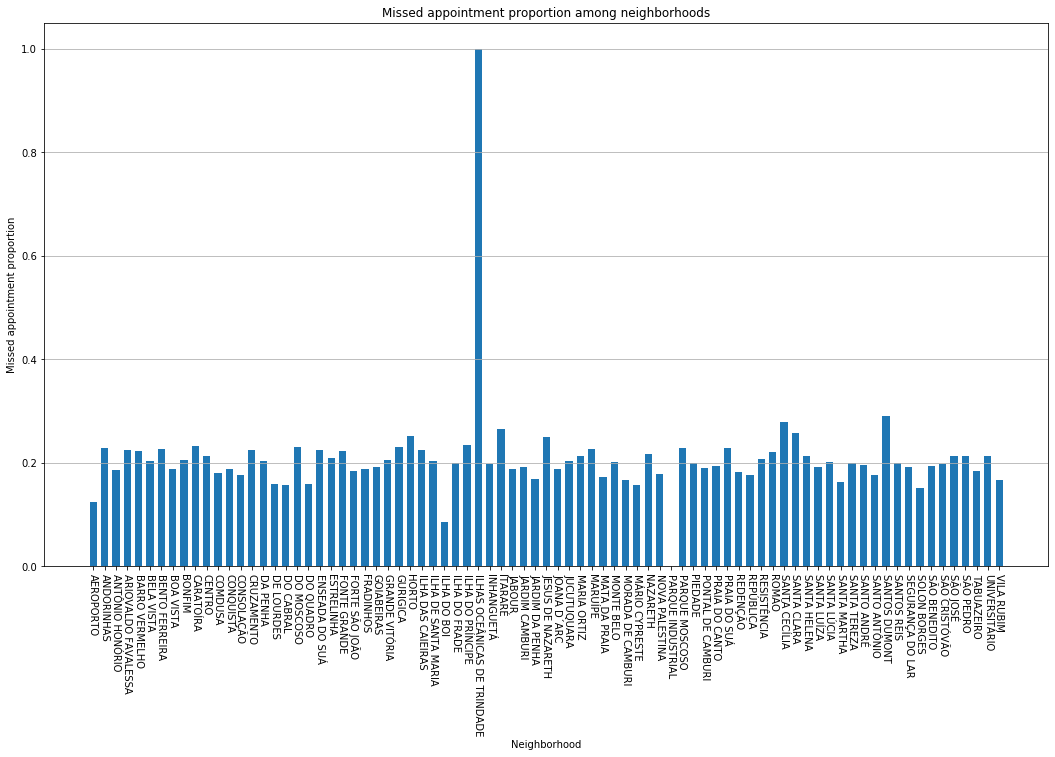

In [25]:
plt.figure(figsize = (18,10))
plt.bar(plot_positions, plot_values)
plt.title('Missed appointment proportion among neighborhoods')
plt.xlabel('Neighborhood')
plt.xticks(plot_positions, plot_labels, rotation = -90)
plt.ylabel('Missed appointment proportion')
plt.grid(axis = 'y');

From the graph we see that for _most_ neighborhoods 20% of all scheduled appointments are missed.  A few outliers that exist (like the one neighborhood with 100% missed appointments) are possibly because of the limited number of data points.

We can verify these observations by calculating a set of descriptive statistics for the missed appointment proportions.

In [26]:
neighborhood_missed_apps.describe()

count    81.000000
mean      0.208709
std       0.096972
min       0.000000
25%       0.183754
50%       0.200385
75%       0.223058
max       1.000000
Name: no_show, dtype: float64

Again, we see that the mean and median values are close to 20%, with a small standard deviation.

In the histogram below, we verify once more that most neighborhoods have missed-appointment rates around 20% with a few  outliers close to 0 and 100%.

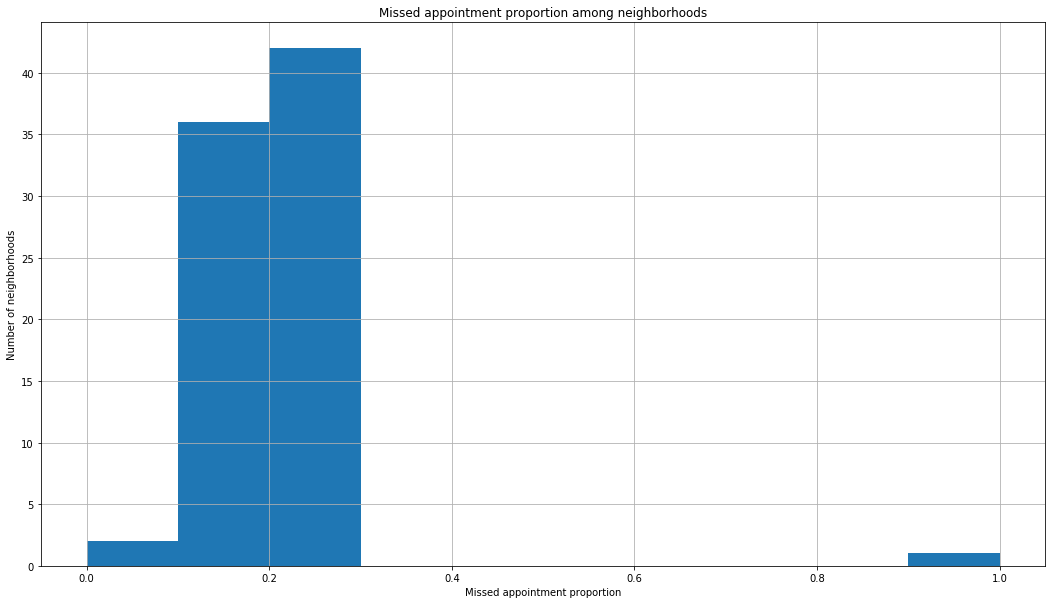

In [27]:
plt.figure(figsize = (18,10))
plt.hist(neighborhood_missed_apps)
plt.title('Missed appointment proportion among neighborhoods')
plt.xlabel('Missed appointment proportion')
plt.ylabel('Number of neighborhoods')
plt.grid();

### Repeatedly missed appointments
In this part of the analysis, we answer the second question posed in the introduction:
>Are there any patients that repeatedly miss their appointment?

We count the number of missed appointments by patient by grouping the data by patient id and calculating the sum of the no-show column.

In [28]:
missed_apps_by_patient = df_doc_apps.groupby('patient_id').sum().no_show

In [29]:
missed_apps_by_patient.describe()

count    62298.000000
mean         0.346817
std          0.634962
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          9.000000
Name: no_show, dtype: float64

As suiggested by the statistics above, more than half of the patients have no missed appointments.
However, there are some extreme cases with up to 9 missed appointments.

The histogram below shows the distribution of patients according to their number of missed appointments.
(Note that, for better readablity, we use logarithmic scale for the vartical axis.)

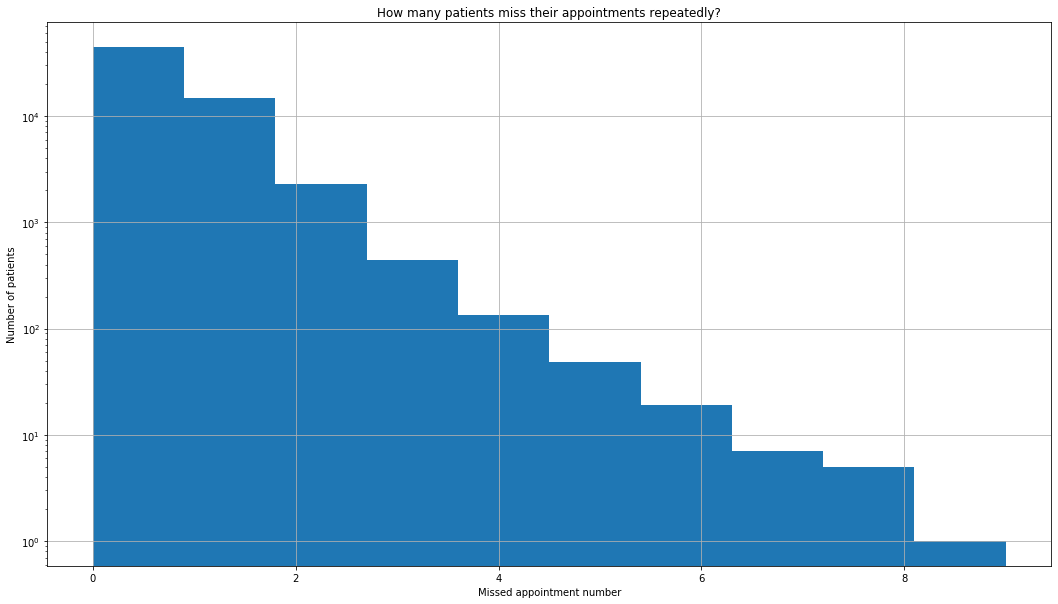

In [30]:
plt.figure(figsize=(18,10))
plt.hist(missed_apps_by_patient)
plt.title('How many patients miss their appointments repeatedly?')
plt.xlabel('Missed appointment number')
plt.ylabel('Number of patients')
plt.yscale('log')
plt.grid();

The histogram above verifies that most patients have 0 or 1 missed appointments but there are also people with multiple 'offences'.

### SMS impact

In this part of the analysis, we answer the third question posed in the introduction:
> Does sending an SMS help reduce the number of people that miss their appointment?

To answer this, we group the data by the number of SMS messages sent to the patient and we calculate the proportion of missed appointments for each group, which is given by then mean of the no-show column.

In [31]:
sms_missed_apps = df_doc_apps.groupby(['sms_received']).mean().no_show
plot_labels = sms_missed_apps.index
plot_values = sms_missed_apps.values
plot_positions = np.linspace(0,1,len(plot_labels))

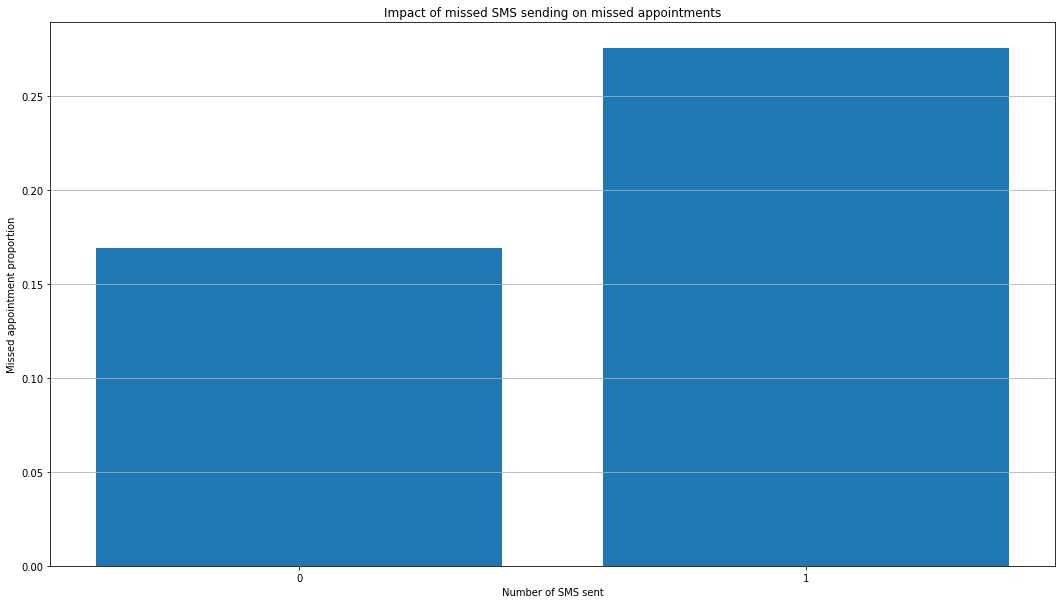

In [32]:
plt.figure(figsize = (18,10))
plt.bar(plot_positions, plot_values)
plt.title('Impact of missed SMS sending on missed appointments')
plt.xlabel('Number of SMS sent')
plt.xticks(plot_positions, plot_labels)
plt.ylabel('Missed appointment proportion')
plt.grid(axis = 'y');

This plot shows that a higher proportion of appointments was missed if an SMS was sent.
This may counterintuitively suggest a negative impact of sending an SMS reminder.
A better statistical test is required in order to determine if this is true.

### Distribution of missed appointments among age groups

In this part of the analysis, we answer the third question posed in the introduction:
> Do older or younger people tend to miss their appointment more?

For the purposes of this analysis, we label people with age less than the median age as 'younger' and people with age higher than the median as 'older' people.
We then group the data for each age group and calculate the missed-appointment proportion.
The results are then plotted below.

In [33]:
min_age = df_doc_apps.age.min()
med_age = df_doc_apps.age.median()
max_age = df_doc_apps.age.max()
bin_edges = [min_age, med_age, max_age]
bin_labels = ['Young', 'Old']
df_doc_apps['age_group'] = pd.cut(df_doc_apps.age, bin_edges, labels = bin_labels)

In [34]:
age_group_missed_apps = df_doc_apps.groupby(['age_group']).mean().no_show
plot_labels = ['Younger (< {})'.format(med_age), 'Older > {})'.format(med_age)]
plot_values = age_group_missed_apps.values
plot_positions = np.linspace(0,1,len(plot_labels))

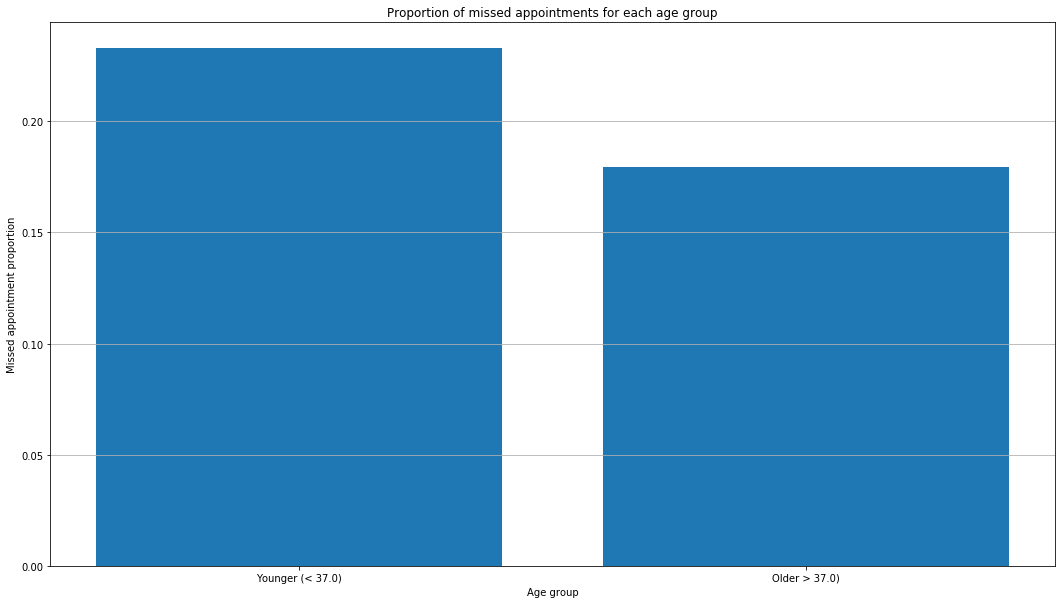

In [35]:
plt.figure(figsize = (18,10))
plt.bar(plot_positions, plot_values)
plt.title('Proportion of missed appointments for each age group')
plt.xlabel('Age group')
plt.xticks(plot_positions, plot_labels)
plt.ylabel('Missed appointment proportion')
plt.grid(axis = 'y');

This plot suggests that the proportion of missed appointments is higher among younger people.

<a id=conclusions></a>
## Conclusions